<a href="https://colab.research.google.com/github/yoyoyo-yo/DeepLearningMugenKnock/blob/master/notes_pytorch/ImgRec/MobileNet_v2_cifar10_pytorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# MobileNet v2

元論文 >> MobileNetV2: Inverted Residuals and Linear Bottlenecks https://arxiv.org/abs/1801.04381

MobileNetを改良したMobileNet-v2では、Convolutionのやり方がさらに変更になっている。

v2ではこのようなconvolutionのブロックを重ねていく。
入力の特徴マップのチャネルをkとする。
tは拡大率で、論文ではt=6としている。

1. Conv(kernel:1x1, channel:tk) + BatchNormalization + ReLU6
2. Depth wise Conv(kernel:1x1, channel:t, stride:(1 or 2)) + BatchNormalization + ReLU6
3. Conv(kernel:1x1, channel:k') + BatchNormalization + ReLU6
4. もし、strideが1なら、skip connectionを加える


<img src="https://github.com/yoyoyo-yo/DeepLearningMugenKnock/blob/master/notes_pytorch/ImgRec/images/mobilenet-v2.png?raw=1" width=500>

ちなみにReLU6とは

y = min(max(0, x), 6)

となった活性化関数を表す。



# torchvision

In [28]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import models

def get_model(out_dim, dropout=0.5, pretrained=True):
    model = mobilenet_v2(pretrained=True)
    del model.fc
    
    model.fc = nn.Sequential(
        nn.Linear(1280, out_dim),
    )

    return model

# scratch

In [29]:
# define feature dimension flattening layer
class Flatten(torch.nn.Module):
    def forward(self, x):
        x = x.view(x.size()[0], -1)
        return x

class MobileNet_v2(nn.Module): 
    def __init__(self, out_dim):
        super(MobileNet_v2, self).__init__()
        
        # define block
        class MobileNetBlock(nn.Module):
            def __init__(self, in_dim, out_dim, stride=1, expansion_t=6, split_division_by=8):
                super(MobileNetBlock, self).__init__()
                
                self.module = torch.nn.Sequential(
                    nn.Conv2d(in_dim, in_dim * expansion_t, kernel_size=1, padding=0, stride=1, groups=in_dim),
                    nn.BatchNorm2d(in_dim * expansion_t),
                    nn.ReLU6(),
                    nn.Conv2d(in_dim * expansion_t, in_dim * expansion_t, kernel_size=3, padding=1, stride=stride, groups=split_division_by),
                    nn.BatchNorm2d(in_dim * expansion_t),
                    nn.ReLU6(),
                    nn.Conv2d(in_dim * expansion_t, out_dim, kernel_size=1, padding=0, stride=1),
                    nn.BatchNorm2d(out_dim),
                )
                    
            def forward(self, _input):
                x = self.module(_input)
                
                # if shape matches, add skip connection
                if x.size() == _input.size():
                    x = x + _input
                return x
        
        self.module = nn.Sequential(
            # input
            # 224 x 224 x 3
            nn.Conv2d(3, 32, kernel_size=3, padding=1, stride=2),
            nn.BatchNorm2d(32),
            nn.ReLU6(),
            # 112 x 112 x 32
            MobileNetBlock(32, 16, expansion_t=1),
            # 112 x 112 x 16
            MobileNetBlock(16, 24, stride=2),
            MobileNetBlock(24, 24),
            # 56 x 56 x 24
            MobileNetBlock(24, 32, stride=2),
            MobileNetBlock(32, 32),
            MobileNetBlock(32, 32),
            # 28 x 28 x 32
            MobileNetBlock(32, 64, stride=2),
            MobileNetBlock(64, 64),
            MobileNetBlock(64, 64),
            MobileNetBlock(64, 64),
            # 14 x 14 x 64
            MobileNetBlock(64, 96),
            MobileNetBlock(96, 96),
            MobileNetBlock(96, 96),
            # 14 x 14 x 96
            MobileNetBlock(96, 160, stride=2),
            MobileNetBlock(160, 160),
            MobileNetBlock(160, 160),
            # 7 x 7 x 160
            MobileNetBlock(160, 320),
            # 7 x 7 x 320
            nn.Conv2d(320, 1280, kernel_size=1, padding=0, stride=1),
            nn.BatchNorm2d(1280),
            nn.ReLU6(),
            # 7 x 7 x 1280
            nn.AdaptiveAvgPool2d([1, 1]),
            Flatten(),
            # 1 x 1 x 1280
            nn.Linear(1280, out_dim),
        )

        
    def forward(self, x):
        x = self.module(x)
        return x

In [30]:
!pip install -q --upgrade albumentations==0.5.1

# Import

In [31]:
import os
import time

from tqdm.notebook import tqdm

import numpy as np
import cv2
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

from sklearn.model_selection import KFold, GroupKFold, StratifiedKFold

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

import albumentations as A
import albumentations.pytorch as Ap

import torchvision
import torchvision.models as models

In [32]:
IN_HEIGHT, IN_WIDTH = 32, 32

RESOURCE = "GPU"

FOLD = "StratifiedKFold" # KFold, GroupKFold, StratifiedKFold, StratifiedGroupXX
FOLD_N = 2 # fold num

RANDOM_SEED = 42

if RESOURCE == "CPU":
    device = torch.device("cpu")
elif RESOURCE == "GPU":
    device = torch.device("cuda")

# prepare data

In [33]:
train_ds = torchvision.datasets.CIFAR10(root="./", train=True, download=True, transform=None)
train_Xs = train_ds.data
train_ys = np.array(train_ds.targets)

class CifarDataset(Dataset):
    def __init__(self, xs, ys, transforms=None):
        self.xs = xs
        self.ys = ys
        self.transforms=transforms
        self.data_num = len(xs)
        
    def __len__(self):
        return self.data_num
    
    def __getitem__(self, idx):
        x = self.xs[idx]
        y = self.ys[idx]

        if self.transforms:
            transformed = self.transforms(image=x)
            x = transformed["image"]
            
        return x, y

Files already downloaded and verified


In [34]:
transforms_train = A.Compose([
    A.RandomResizedCrop(IN_HEIGHT, IN_WIDTH, scale = (0.9,1.0),ratio = (0.9,1.1),p=1.0),
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.ShiftScaleRotate(p=0.5),
    A.RandomRotate90(p=0.5),
    A.HueSaturationValue(hue_shift_limit=0.1, sat_shift_limit=0.1,val_shift_limit=0.1,p=0.2),
    A.RandomBrightnessContrast(brightness_limit = (-0.2,0.2), contrast_limit = (-0.1,0.1), p=0.2),
    A.Normalize(max_pixel_value=255.0, p=1.0),
    A.CoarseDropout(p=0.5),
    A.Cutout(p=0.5),
    Ap.ToTensorV2(p=1.0),
])

transforms_val = A.Compose([
    A.Resize(IN_HEIGHT, IN_WIDTH),
    A.Normalize(max_pixel_value=255.0, p=1.0),
    Ap.ToTensorV2(p=1.0),
])

# Train

In [35]:
def train():
    # fold
    if FOLD == "KFold":
        kf = KFold(n_splits=FOLD_N, shuffle=True, random_state=RANDOM_SEED)
        spl = kf.split(train_ds)
        
    elif FOLD == "GroupKFold":
        kf = GroupKFold(n_splits=FOLD_N)
        spl = kf.split(train_ds.data, train_ds.targets, train_ds.targets)
        
    elif FOLD == "StratifiedKFold":
        kf = StratifiedKFold(n_splits=FOLD_N, shuffle=True, random_state=RANDOM_SEED)
        spl = kf.split(train_ds.data, train_ds.targets)

    else:
        print("invalid fold")
        return None
    
    train_models = []
    train_model_paths = []

    val_cv_loss = []
    val_cv_accuracy = []
    
    val_cv_labels = []
    val_cv_preds = []

    EPOCH = 30
    
    for fold_i, (train_idx, val_idx) in enumerate(spl):
        
        train_losses = []
        val_losses = []
        train_accuracies = []
        val_accuracies = []
        
        print(f"{FOLD} fold:{fold_i + 1}/{FOLD_N}")
        print(f"train_N={len(train_idx)}, val_N={len(val_idx)}")
            
        #---
        # datasert
        #---
        X_train = train_Xs[train_idx]
        y_train = train_ys[train_idx]
        X_val = train_Xs[val_idx]
        y_val = train_ys[val_idx]

        dataset_train = CifarDataset(X_train, y_train, transforms=transforms_train)
        dataset_val = CifarDataset(X_val, y_val, transforms=transforms_val)

        dataloader_train = DataLoader(dataset_train, batch_size=256, num_workers=4, shuffle=True, pin_memory=True)
        dataloader_val = DataLoader(dataset_val, batch_size=256, num_workers=4, shuffle=False, pin_memory=True)
        
        train_n = len(X_train)
        val_n = len(X_val)
        target_n = 1
        
        #---
        # model
        #---
        # model = get_model(out_dim=10, pretrained=True, dropout=0.5)
        model = MobileNet_v2(out_dim=10)
        model = model.to(device)
        
        criterion = nn.CrossEntropyLoss(reduction="sum")
        # criterion = nn.BCELoss(reduction="sum")
        # optimizer = optim.SGD(model.parameters(), lr=0.01)
        optimizer = optim.Adam(model.parameters(), lr=0.001)
        # lr_scheduler = optim.lr_scheduler.MultiStepLR(optimizer=optimizer, milestones=[50], gamma=0.1, last_epoch=-1)
    
        #---
        # epoch
        #---
        for epoch in range(EPOCH):

            model.train()
            
            tr_loss = 0
            correct = 0
            total = 0
            
            #---
            # train
            #---
            train_time_start = time.time()
            
            for step, batch in enumerate(dataloader_train):
                optimizer.zero_grad()

                xs = batch[0].to(device) # image
                ys = batch[1].to(device) # target
            
                outputs = model(xs)
             
                loss = criterion(outputs, ys)
                        
                loss = loss / train_n
                loss.backward()

                loss = loss.item()
                tr_loss += loss
                
                _, predicted = torch.max(outputs.data, 1)
                total += ys.size(0)
                correct += (predicted == ys).sum().item()

                optimizer.step()

            train_losses.append(tr_loss)
            
            train_accuracy = correct / total
            train_accuracies.append(train_accuracy)

            train_time_end = time.time()

            #---
            # val
            #---
            model.eval()

            val_loss = 0
            val_correct = 0
            val_total = 0
            
            val_time_start = time.time()
            
            val_labels = []
            val_preds = []
            
            with torch.no_grad():
                for step, batch in enumerate(dataloader_val):
                    xs = batch[0].to(device) # image
                    ys = batch[1].to(device) # target
                    
                    outputs = model(xs)

                    loss = criterion(outputs, ys)
                        
                    val_loss += loss.item() / val_n
                    
                    _, predicted = torch.max(outputs.data, 1)
                    val_total += ys.size(0)
                    val_correct += (predicted == ys).sum().item()
                    
                    val_labels.extend(ys.detach().cpu().numpy().tolist())
                    val_preds.extend(predicted.detach().cpu().numpy().tolist())

            val_time_end = time.time()
            train_time_total = train_time_end - train_time_start
            val_time_total = val_time_end - val_time_start
            total_time = train_time_total + val_time_total
                
            val_losses.append(val_loss)
            
            val_accuracy = val_correct / val_total
            val_accuracies.append(val_accuracy)

            print(f"fold:{fold_i + 1} epoch:{epoch + 1}/{EPOCH} [tra]loss:{tr_loss:.4f} acc:{train_accuracy:.4f}  [val]loss:{val_loss:.4f} acc:{val_accuracy:.4f}  [time]total:{total_time:.2f}sec tra:{train_time_total:.2f}sec val:{val_time_total:.2f}sec")

#             lr_scheduler.step()


            if (epoch + 1) % 100 == 0:
                savename = f"model_epoch{epoch + 1}_{EPOCH}_{FOLD}_{fold_i + 1}_{FOLD_N}.pth"
                torch.save(model.state_dict(), savename)
                print(f"model saved to >> {savename}")

        #---
        # store last val loss and accuracy
        #---
        val_cv_loss.append(val_loss)
        val_cv_accuracy.append(val_accuracy)
        
        val_cv_labels.extend(val_labels)
        val_cv_preds.extend(val_preds)
           
        #---
        # save model
        #---
        savename = f"model_epoch{EPOCH}_{FOLD}_{fold_i + 1}_{FOLD_N}.pth"
        torch.save(model.state_dict(), savename)
        print(f"model saved to >> {savename}")
        print()
        
        train_models.append(model)
        train_model_paths.append(savename)
        

        fig, ax1 = plt.subplots()
        ax2 = ax1.twinx()
        ax1.grid()
        ax1.plot(train_losses, marker=".", markersize=6, color="red", label="train loss")
        ax1.plot(val_losses, marker=".", markersize=6, color="blue", label="val loss")
        ax2.plot(train_accuracies, marker=".", markersize=6, color="green", label="train accuracy")
        ax2.plot(val_accuracies, marker=".", markersize=6, color="orange", label="val accuracy")
        h1, l1 = ax1.get_legend_handles_labels()
        h2, l2 = ax2.get_legend_handles_labels()
        ax1.legend(h1+h2, l1+l2, loc="upper right")
        ax1.set(xlabel="Epoch", ylabel="Loss")
        ax2.set(ylabel="Accuracy")
        plt.show()
        
    
    #---
    # display fold score
    #---
    val_cv_loss = np.array(val_cv_loss)
    val_cv_accuracy = np.array(val_cv_accuracy)
    
    print("all folds score")
    print(f"total loss:{val_cv_loss.mean():.6f}, accuracy:{val_cv_accuracy.mean():.6f}")
    for i in range(FOLD_N):
        print(f"fold{i + 1}/{FOLD_N} loss:{val_cv_loss[i]:.6f}, accuracy:{val_cv_accuracy[i]:.6f}")
        
    #---
    # label x pred
    #---
    res_df = pd.DataFrame({"label":val_cv_labels, "pred":val_cv_preds})
    print()
    print("cross table")
    display(pd.crosstab(res_df["label"], res_df["pred"]))
        
    return train_models, train_model_paths

StratifiedKFold fold:1/2
train_N=25000, val_N=25000
fold:1 epoch:1/30 [tra]loss:2.1855 acc:0.1709  [val]loss:2.1095 acc:0.2267  [time]total:20.65sec tra:17.69sec val:2.96sec
fold:1 epoch:2/30 [tra]loss:2.0200 acc:0.2294  [val]loss:2.0013 acc:0.2646  [time]total:20.82sec tra:17.89sec val:2.93sec
fold:1 epoch:3/30 [tra]loss:1.9612 acc:0.2600  [val]loss:1.9839 acc:0.2750  [time]total:20.75sec tra:17.82sec val:2.93sec
fold:1 epoch:4/30 [tra]loss:1.9232 acc:0.2776  [val]loss:1.8252 acc:0.3278  [time]total:20.74sec tra:17.74sec val:3.00sec
fold:1 epoch:5/30 [tra]loss:1.8783 acc:0.3025  [val]loss:1.8384 acc:0.3272  [time]total:20.89sec tra:17.89sec val:3.00sec
fold:1 epoch:6/30 [tra]loss:1.8533 acc:0.3120  [val]loss:1.8112 acc:0.3441  [time]total:20.66sec tra:17.70sec val:2.96sec
fold:1 epoch:7/30 [tra]loss:1.8196 acc:0.3278  [val]loss:1.7380 acc:0.3665  [time]total:20.89sec tra:17.94sec val:2.95sec
fold:1 epoch:8/30 [tra]loss:1.7878 acc:0.3445  [val]loss:1.6785 acc:0.3740  [time]total:20.74s

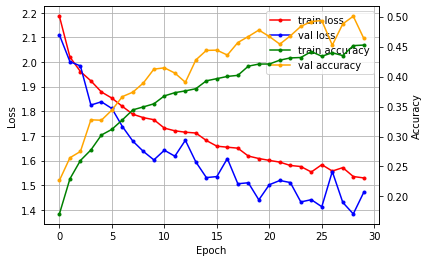

StratifiedKFold fold:2/2
train_N=25000, val_N=25000
fold:2 epoch:1/30 [tra]loss:2.2407 acc:0.1628  [val]loss:2.1004 acc:0.2104  [time]total:20.79sec tra:17.81sec val:2.98sec
fold:2 epoch:2/30 [tra]loss:2.0452 acc:0.2293  [val]loss:1.9699 acc:0.2578  [time]total:20.77sec tra:17.75sec val:3.02sec
fold:2 epoch:3/30 [tra]loss:1.9745 acc:0.2519  [val]loss:1.8814 acc:0.2846  [time]total:20.69sec tra:17.75sec val:2.94sec
fold:2 epoch:4/30 [tra]loss:1.9215 acc:0.2796  [val]loss:1.8291 acc:0.3179  [time]total:20.78sec tra:17.82sec val:2.97sec
fold:2 epoch:5/30 [tra]loss:1.8932 acc:0.2972  [val]loss:1.7723 acc:0.3404  [time]total:20.64sec tra:17.63sec val:3.01sec
fold:2 epoch:6/30 [tra]loss:1.8554 acc:0.3100  [val]loss:1.8154 acc:0.3411  [time]total:20.94sec tra:17.92sec val:3.02sec
fold:2 epoch:7/30 [tra]loss:1.8251 acc:0.3320  [val]loss:1.7603 acc:0.3476  [time]total:20.83sec tra:17.86sec val:2.97sec
fold:2 epoch:8/30 [tra]loss:1.8070 acc:0.3351  [val]loss:1.7043 acc:0.3791  [time]total:20.68s

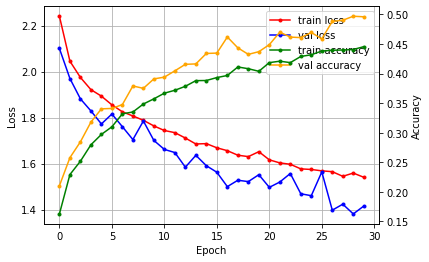

all folds score
total loss:1.443274, accuracy:0.479820
fold1/2 loss:1.471306, accuracy:0.463600
fold2/2 loss:1.415242, accuracy:0.496040

cross table


pred,0,1,2,3,4,5,6,7,8,9
label,,,,,,,,,,
0,2877,770,166,59,62,118,49,83,528,288
1,140,4153,14,26,2,47,71,34,103,410
2,633,450,1356,170,563,414,557,550,187,120
3,168,458,199,961,195,1206,844,409,205,355
4,239,105,533,171,1639,195,856,963,136,163
5,111,386,195,611,191,2077,436,618,155,220
6,59,253,160,169,312,102,3613,175,50,107
7,145,396,114,195,271,454,279,2715,56,375
8,1168,753,30,49,44,88,44,23,2516,285


In [36]:
train_models, train_model_paths = train()

# Test

In [37]:
# test
def test(train_models):
    for model in train_models:
        model.eval()

    model_num = len(train_models)

    test_ds = torchvision.datasets.CIFAR10(root="./", train=False, download=True, transform=None)
    test_Xs = test_ds.data
    test_ys = np.array(test_ds.targets)

    dataset_test = CifarDataset(test_Xs, test_ys, transforms=transforms_val)
    dataloader_test = DataLoader(dataset_test, batch_size=512, num_workers=4, shuffle=False, pin_memory=True)

    preds = []
    correct = 0

    with torch.no_grad():
         for step, batch in enumerate(dataloader_test):
            Xs = batch[0].to(device) # image
            ys = batch[1]

            _preds = np.zeros([len(ys), 10])

            for model in train_models:
                model_preds = F.softmax(model(Xs), dim=1).detach().cpu().numpy()
                _preds += model_preds / model_num

            _preds = _preds.argmax(axis=1)

            preds.extend(_preds)

            correct += sum(ys.numpy() == _preds)

    #---
    # label x pred
    #---
    res_df = pd.DataFrame({"label":test_ys, "pred":preds})
    print()
    print("cross table")
    cross = pd.crosstab(res_df["label"], res_df["pred"])

    accuracy = correct / len(test_ys)
    print(f"accuracy = {accuracy:.4f} ({correct} / {len(test_ys)})")

    display(cross)


test(train_models)

Files already downloaded and verified

cross table
accuracy = 0.5101 (5101 / 10000)


pred,0,1,2,3,4,5,6,7,8,9
label,,,,,,,,,,
0,624,130,28,8,11,15,10,23,103,48
1,18,872,0,0,0,5,15,5,19,66
2,128,87,269,31,119,78,118,117,32,21
3,36,88,38,190,40,226,189,92,34,67
4,41,21,119,29,359,22,171,195,27,16
5,24,77,41,96,28,453,81,132,33,35
6,3,53,39,28,36,13,780,21,11,16
7,33,68,14,39,27,89,52,588,14,76
8,184,147,5,10,11,20,6,5,563,49
